In [1]:
!pip install gensim
!pip install pyLDAvis
!pip install spacy
!pip install wordcloud
!pip install nltk
!pip install scikit-learn
!pip install scipy

!python -m spacy download

     |████████████████████████████████| 1.7MB 6.1MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135593 sha256=14b2cf50da60afefe1d08186bf9903dae7393022e9199b670ffa602daeefa745
  Stored in directory: /root/.cache/pip/wheels/74/df/b6/97234c8446a43be05c9a8687ee0db1f1b5ade5f27729187eae
Successfully built pyLDAvis

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -m


In [3]:
!pip install spacy
!python -m spacy download

usage: spacy download [-h] [-d] model [pip_args [pip_args ...]]
spacy download: error: the following arguments are required: model


In [131]:
### import libraries

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

import gensim
import numpy as np
import spacy
import math

from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import ldamallet
from gensim.corpora import Dictionary
import pyLDAvis.gensim

import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

import os, re, operator, warnings
warnings.filterwarnings('ignore')
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [63]:
def clean(text):
  return str(''.join([i if ord(i) < 128 else ' ' for i in text]))

test_data_dir = '{}'.format(os.sep).join([gensim.__path__[0], 'test', 'test_data'])
lee_train_file = test_data_dir + os.sep + 'lee_background.cor'

In [64]:
text = open(lee_train_file).read()
nlp = spacy.load('en_core_web_sm')
stop_words = stopwords.words('english')

In [65]:
for stopword in stop_words:
  lexeme = nlp.vocab[stopword]
  lexeme.is_stop = True

In [66]:
doc = nlp(clean(text))

In [67]:
# doc

In [68]:
texts, article = [], []
for w in doc:
  if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num:
    article.append(w.lemma_)
  if w.text == '\n':
    texts.append(article)
    article = []

In [69]:
# texts

In [70]:
transformed_texts = [' '.join(i) for i in texts]

In [71]:
transformed_texts_1 = [i.lower() for i in transformed_texts]

In [72]:
transformed_texts_2 = [re.sub(r'\w*\d\w*', '', i).strip() for i in transformed_texts_1]

In [73]:
# transformed_texts_2

In [74]:
unique_adj = []

for text in doc:
    if text.pos_ == 'ADJ':
      if text not in unique_adj:
        unique_adj.append(text)

len(unique_adj)

4199

In [75]:
unique_adjectives = []

for text in transformed_texts_2:
  transformed = nlp(text)
  for token in transformed:
   if token.pos_ == 'ADJ':
    if token.lemma_ not in unique_adjectives:
     unique_adjectives.append(token.lemma_)

len(unique_adjectives)

828

In [76]:
adj = []

for text_ in transformed_texts_2:
  doc = nlp(text_)
  adj.append([token.text for token in doc if token.pos_=='ADJ'])

In [80]:
from itertools import chain
adj_ = list(chain(*adj))
adj___ = list(set(adj_))

In [81]:
len(adj___)

835

In [82]:
unique_entities = []

for text in transformed_texts_2:
  transformed = nlp(text)
  for ent in transformed.ents:
    if ent.text not in unique_entities:
     unique_entities.append(ent.text)

len(unique_entities)

1735

In [142]:
### TF-IDF

def IDF(corpus, unique_words):
  idf_dict = {}
  N = len(corpus)
  for i in unique_words:
    count = 0
    for sen in corpus:
      if i in sen.split():
        count += 1
      idf_dict[i] = (math.log((N+1)/(count+1)))+1
  return idf_dict

def fit(whole_data):
  unique_words = set()
  if isinstance(whole_data, (list,)):
    for x in whole_data:
      for y in x.split():
        if len(y)<2:
          continue
        unique_words.add(y)
    unique_words = sorted(list(unique_words))
    vocab = {j:i for i,j in enumerate(unique_words)}
    Idf_values_of_all_unique_words = IDF(whole_data, unique_words)
  return vocab, Idf_values_of_all_unique_words

def transform(dataset, vocabulary, idf_values):
  vocab = {}
  sparse_matrix = csr_matrix((len(dataset), len(vocabulary)), dtype = np.float64)
  for row in range(0, len(dataset)):
    number_of_words_in_sentence = Counter(dataset[row].split())
    for word in dataset[row].split():
      if word in list(vocabulary.keys()):
        tf_idf_value = (number_of_words_in_sentence[word]/len(dataset[row].split()))*idf_values[word]
        sparse_matrix[row, vocabulary[word]] = tf_idf_value
        vocab[word] = tf_idf_value
  return vocab


In [89]:
Vocabulary, idf_of_vocabulary = fit(transformed_texts_2)

In [93]:
sorted_idf = dict(sorted(idf_of_vocabulary.items(), key = operator.itemgetter(1), reverse = True))

<function matplotlib.pyplot.show>

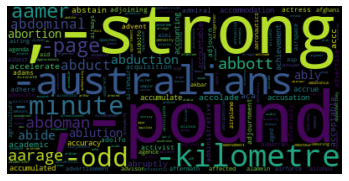

In [94]:
wordcloud = WordCloud().generate_from_frequencies(idf_of_vocabulary)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show

In [97]:
stop_words.extend(['aamer'])
stopwords_dict = Counter(stop_words)
transformed_texts_3 = [' '.join([word for word in i.split() if word not in stopwords_dict]) for i in transformed_texts_2]

<function matplotlib.pyplot.show>

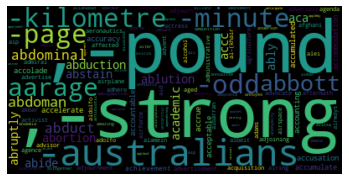

In [99]:
Vocabulary, idf_of_vocabulary = fit(transformed_texts_3)

wordcloud = WordCloud().generate_from_frequencies(idf_of_vocabulary)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show

In [141]:
csr_matrix((len(transformed_texts_3), len(Vocabulary)), dtype = np.float64)

<299x5330 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [143]:
final_output = transform(transformed_texts_3, Vocabulary, idf_of_vocabulary)

<function matplotlib.pyplot.show>

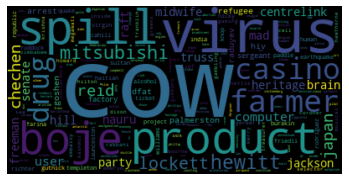

In [144]:
wordcloud = WordCloud().generate_from_frequencies(final_output)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show

In [108]:
### Shortcut

tfidf = TfidfVectorizer(sublinear_tf = True, norm = 'l2', min_df = 5, encoding = 'latin-1', ngram_range = (1,1), stop_words = stop_words)
features = tfidf.fit_transform(transformed_texts_3)
d = tfidf.vocabulary_


<function matplotlib.pyplot.show>

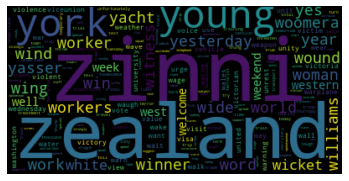

In [109]:
wordcloud = WordCloud().generate_from_frequencies(d)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show

In [110]:
### vader

sid = SentimentIntensityAnalyzer()
for i in range(len(transformed_texts_3)):
  print(transformed_texts_3[i]+':')
  scores = sid.polarity_scores(transformed_texts_3[i])
  print(scores)

hundred people force vacate home southern highlands new south wales strong wind today push huge bushfire town hill new blaze near goulburn south west sydney force closure hume highway : aedt marked deterioration weather storm cell move east blue mountains force authority decision evacuate people home outlying street hill new south wales southern highland estimated resident leave home nearby mittagong new south wales rural fire service say weather condition cause fire burn finger formation ease fire unit hill optimistic defend property blaze burn new year eve new south wales fire crew call new fire gunning south goulburn detail available stage fire authority say close hume highway direction new fire sydney west longer threaten property cranebrook area rain fall part illawarra sydney hunter valley north coast bureau meteorology claire richards say rain little ease fire burn state fall isolate area generally fall millimetre say place significant millimetre relief far rain concern fact pro

In [111]:
### Topic Modeling
# hierarchical dirichlet, latent sentiment indexing??, latent 

bigram = gensim.models.Phrases(texts)
texts = [bigram[line] for line in texts]

In [115]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [120]:
lsimodel = LsiModel(corpus = corpus, num_topics=10, id2word=dictionary)

In [123]:
lsimodel.show_topics(10)

[(0,
  '0.789*"say" + 0.142*"Mr" + 0.097*"israeli" + 0.095*"force" + 0.094*"people" + 0.083*"Australia" + 0.082*"kill" + 0.080*"attack" + 0.079*"official" + 0.078*"palestinian"'),
 (1,
  '-0.394*"israeli" + -0.336*"palestinian" + -0.285*"Mr_Arafat" + -0.192*"Israel" + -0.178*"official" + 0.165*"say" + -0.165*"Hamas" + -0.154*"kill" + -0.151*"West_Bank" + -0.137*"attack"'),
 (2,
  '-0.312*"Afghanistan" + -0.293*"force" + -0.220*"Al_Qaeda" + -0.196*"bin_Laden" + -0.161*"fighter" + -0.154*"Tora_Bora" + -0.154*"Taliban" + -0.146*"Pakistan" + -0.119*"afghan" + 0.112*"fire"'),
 (3,
  '-0.404*"fire" + -0.293*"area" + -0.246*"Sydney" + -0.196*"firefighter" + -0.178*"north" + -0.170*"wind" + -0.168*"Wales" + -0.168*"New_South" + -0.142*"south" + -0.129*"line"'),
 (4,
  '0.248*"Mr" + -0.234*"test" + -0.228*"Australia" + -0.216*"day" + -0.197*"match" + -0.183*"South_Africa" + -0.176*"wicket" + -0.160*"good" + -0.157*"play" + -0.132*"catch"'),
 (5,
  '0.341*"Mr" + -0.315*"say" + 0.219*"force" + 0.

In [124]:
ldamodel = LdaModel(corpus = corpus, num_topics=10, id2word=dictionary)

In [125]:
ldamodel.show_topics()

[(0,
  '0.022*"say" + 0.007*"Mr" + 0.006*"year" + 0.004*"good" + 0.004*"Australia" + 0.004*"people" + 0.003*"australian" + 0.003*"day" + 0.003*"cent" + 0.003*"time"'),
 (1,
  '0.015*"say" + 0.004*"know" + 0.004*"report" + 0.003*"Government" + 0.003*"day" + 0.003*"Hamas" + 0.003*"fire" + 0.003*"Australia" + 0.003*"people" + 0.003*"force"'),
 (2,
  '0.010*"say" + 0.006*"kill" + 0.005*"palestinian" + 0.004*"israeli" + 0.004*"people" + 0.004*"force" + 0.004*"group" + 0.004*"militant" + 0.004*"attack" + 0.004*"Mr"'),
 (3,
  '0.038*"say" + 0.006*"Mr" + 0.004*"United_States" + 0.004*"man" + 0.003*"tell" + 0.003*"people" + 0.003*"israeli" + 0.003*"arrest" + 0.003*"Sydney" + 0.003*"area"'),
 (4,
  '0.028*"say" + 0.005*"day" + 0.005*"Mr" + 0.004*"new" + 0.004*"Afghanistan" + 0.004*"force" + 0.004*"official" + 0.004*"union" + 0.003*"year" + 0.003*"Government"'),
 (5,
  '0.019*"say" + 0.007*"people" + 0.004*"attack" + 0.004*"claim" + 0.004*"area" + 0.003*"Government" + 0.003*"fire" + 0.003*"report

In [126]:
#to let model select number of topics, do not include num_toppic
hdpmodel = HdpModel(corpus = corpus, id2word=dictionary)
hdpmodel.show_topics()

[(0,
  '0.006*say + 0.004*group + 0.003*kill + 0.003*call + 0.003*palestinian + 0.002*Government + 0.002*people + 0.002*guide + 0.002*face + 0.002*canyone + 0.002*choose + 0.002*attack + 0.002*Adventure_World + 0.002*year + 0.002*Interlaken + 0.002*terrorism + 0.002*meeting + 0.002*security + 0.002*israeli + 0.002*allow'),
 (1,
  '0.007*say + 0.003*storm + 0.003*tree + 0.003*Harrison + 0.002*damage + 0.002*  + 0.002*work + 0.002*bring + 0.002*die + 0.002*Australia + 0.002*Sydney + 0.002*SES + 0.002*night + 0.002*hit + 0.002*George + 0.002*day + 0.001*home + 0.001*Beatle + 0.001*area + 0.001*Mr'),
 (2,
  '0.007*say + 0.003*airport + 0.003*Taliban + 0.002*kill + 0.002*night + 0.002*opposition + 0.002*Kandahar + 0.002*Gul + 0.002*near + 0.002*Lali + 0.002*city + 0.001*Federal_Police + 0.001*civilian + 0.001*position + 0.001*Agha + 0.001*leave + 0.001*half + 0.001*wounded + 0.001*bombing + 0.001*Jalalabad'),
 (3,
  '0.005*say + 0.003*australian + 0.002*cent + 0.002*job + 0.002*November + 0

In [127]:
#does not work for lsi since this uses dimension reduction (PCA)
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel,corpus,dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.018625 -0.019663       1        1  19.116451
9     -0.035440 -0.037494       2        1  17.484850
4     -0.001451 -0.014913       3        1  12.838603
8      0.000439 -0.016364       4        1  10.829210
6      0.039393  0.003968       5        1  10.639309
5     -0.009996  0.021006       6        1   7.064256
0      0.068037 -0.019965       7        1   7.048592
7     -0.026115  0.005758       8        1   5.580774
2      0.000340  0.067417       9        1   5.458934
1     -0.016582  0.010251      10        1   3.939022, topic_info=             Term        Freq       Total Category  logprob  loglift
90            say  814.000000  814.000000  Default  30.0000  30.0000
1005           Mr  159.000000  159.000000  Default  29.0000  29.0000
855   palestinian   63.000000   63.000000  Default  28.0000  28.0000
82         people  108.000000  108.000000  Default  27.0000  27.0000
848       israeli   79.000000   79.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
77            new    2.373763   66.590156  Topic10  -6.2068  -0.0998
34           call    2.210735   53.551408  Topic10  -6.2780   0.0469
1005           Mr    2.565877  159.424596  Topic10  -6.1290  -0.8950
851         month    2.146972   51.402187  Topic10  -6.3072   0.0586
310   Afghanistan    2.117441   69.317834  Topic10  -6.3211  -0.2543

[799 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
646       1  0.150155           
646       2  0.214507           
646       3  0.128704           
646       4  0.128704           
646       5  0.085803           
...     ...       ...        ...
180       6  0.120165  yesterday
180       7  0.048066  yesterday
180       8  0.024033  yesterday
180       9  0.048066  yesterday
180      10  0.048066  yesterday

[2204 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 10, 5, 9, 7, 6, 1, 8, 3, 2])

In [129]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted = False)]
hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted = False)]
ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted = False)]


In [132]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=texts, dictionary = dictionary, window_size=10).get_coherence()
hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=texts, dictionary = dictionary, window_size=10).get_coherence()
lda_coherence = CoherenceModel(topics=ldatopics[:10], texts=texts, dictionary = dictionary, window_size=10).get_coherence()

In [133]:
def evaluate_bar_graph(coherences, indices):
  assert len(coherences) == len(indices)
  n = len(coherences)
  x = np.arange(n)
  plt.bar(x,coherences, width = 0.2, tick_label = indices, align='center')
  plt.xlabel('Models')
  plt.ylabel('Coherence Value')
  plt.title('Topic Model Performance')


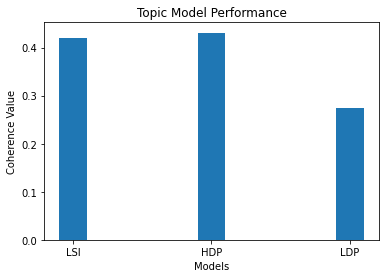

In [134]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence], ['LSI', 'HDP','LDA'])